In [1]:
# import libraries
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [2]:
# set file paths
DATA_DIR = Path("../Datasets/Open University Learning Analytics Dataset (OULAD)")

# set CSV file names
CSV_FILES = {
    "courses": "courses.csv",
    "assessments": "assessments.csv",
    "vle": "vle.csv",
    "studentInfo": "studentInfo.csv",
    "studentRegistration": "studentRegistration.csv",
    "studentAssessment": "studentAssessment.csv",
    "studentVLE": "studentVLE.csv"
}
 
# set categorical columns to reduce memory usage
CAT_COLS = {
    "courses": ["code_module", "code_presentation"],
    "assessments": ["code_module", "code_presentation", "assessment_type"],
    "vle": ["code_module", "code_presentation", "activity_type"],
    "studentInfo": ["code_module", "code_presentation", "gender", "region", "highest_education", "imd_band", "age_band", "disability", "final_result"],
    "studentRegistration": ["code_module", "code_presentation"],
    "studentAssessment": [],
    "studentVLE": ["code_module", "code_presentation"]
}

# read files into a dictionary as dataframes
dfs = {} 
for name, file in CSV_FILES.items():
    path = DATA_DIR / file
    cat_map = {col: "category" for col in CAT_COLS[name]}
    try:
        dfs[name] = pd.read_csv(path, dtype=cat_map, low_memory=False)
    except FileNotFoundError:
        print(f"File not found: {file}")

# summarise in a table
summary = []
for name, df in dfs.items():
    summary.append({
        "Table": name,
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Missing (%)": round(df.isna().mean().mean() * 100, 2),
        "Memory (MB)": round(df.memory_usage(deep=True).sum() / 1_048_576, 2)
    })

summary_df = pd.DataFrame(summary).sort_values(by="Table")
display(summary_df)


,Table,Rows,Columns,Missing (%),Memory (MB)
1,assessments,206,6,0.89,0.01
0,courses,22,3,0.00,0.00
5,studentAssessment,173912,5,0.02,6.63
3,studentInfo,32593,12,0.28,1.03
4,studentRegistration,32593,5,13.85,0.81
6,studentVLE,10655280,6,0.00,345.50
2,vle,6364,6,27.46,0.17


# Combine Datasets

### Step 1: Remove VLE Interaction data after the 25% course cutoff
This step is done early as it removes over 5 million rows of interaction data, reducing computational load later on.

In [3]:
# add early_cutoff column to 'courses' to define first 25% cutoff
dfs["courses"]["early_cutoff"] = 0.25 * dfs["courses"]["module_presentation_length"]
 
# merge 'studentVLE' and 'courses' to filter VLE interactions after cutoff
vle_interactions_shortened = dfs["studentVLE"].merge(dfs["courses"], on=["code_module", "code_presentation"], how="left")
vle_interactions_shortened = vle_interactions_shortened[vle_interactions_shortened["date"] <= vle_interactions_shortened["early_cutoff"]]
 
# aggregate VLE interactions to get total interactions per enrolment
vle_interactions_aggregated = vle_interactions_shortened.groupby(
    ["id_student", "code_module", "code_presentation"], observed=True).agg(
        sum_click=("sum_click", "sum"),
        days_clicked=("date", "nunique")
        ).reset_index()

### Step 2: Remove Assessment Submission data after the 25% course cutoff

In [4]:
# merge 'studentAssessment' with 'assessments' and 'courses'
assessments_combined = dfs["studentAssessment"].merge(dfs["assessments"],on=["id_assessment"],how="left")
assessments_combined = assessments_combined.merge(dfs["courses"][["code_module", "code_presentation", "early_cutoff"]], 
                                                  on=["code_module", "code_presentation"], how="left")

# filter out exams as they are at the end of course and have no date in the datasets, and assessments after the 25% course cutoff
assessments_combined = assessments_combined[(assessments_combined["assessment_type"] != "Exam") &
                (assessments_combined["date_submitted"] <= assessments_combined["early_cutoff"]) &
                assessments_combined["score"].notna()]
 
# create binary flag for failed assessments
assessments_combined["failed_assessment"] = (assessments_combined["score"] < 40).astype(int)
 
# weighted score
assessments_combined["weighted_score"] = (assessments_combined["score"] * assessments_combined["weight"])
 
# aggregate per enrolment: weighted avg and total weight
early_assessment_features = assessments_combined.groupby(
    ["id_student", "code_module", "code_presentation"], observed=True
    ).agg(early_weighted_avg_score=("weighted_score", "sum"),
    total_weight=("weight", "sum")).reset_index()

# calculate actual weighted average score
early_assessment_features["early_weighted_avg_score"] /= early_assessment_features["total_weight"]
early_assessment_features.drop(columns="total_weight", inplace=True)

# create binary flag per enrolment: did they fail any early assessment?
early_fail_flag = assessments_combined.groupby(
    ["id_student", "code_module", "code_presentation"], observed=True
)["failed_assessment"].max().reset_index().rename(columns={"failed_assessment": "early_failed_assessment"})

# merge the fail flag into the main feature set
early_assessment_features = early_assessment_features.merge(early_fail_flag,
                 on=["id_student", "code_module", "code_presentation"],how="left")

### Step 3: Merge datasets to create combined file
As the project aims to predict outcomes of singlular student course enrolment instances, the final dataset must have one row per course enrolment, not per student. Hence, StudentInfo is used as the base as it has this format. Other datasets are merged using unique identifiers. 

In [5]:
# create new df building on studentInfo
df_combined = dfs["studentInfo"].copy()
 
# merge with 'studentRegistration' to get add course enrolment/withdrawal columns
df_combined = df_combined.merge(
    dfs["studentRegistration"],
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)
 
# merge with 'courses' to get course length
df_combined = df_combined.merge(dfs["courses"], on=["code_module", "code_presentation"], how="left")
 
# merge with 'vle_interactions_aggregated' to get VLE interaction data
df_combined = df_combined.merge(
    vle_interactions_aggregated,
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)
 
# merge with 'early_assessment_features' to get assessment data
df_combined = df_combined.merge(
    early_assessment_features,
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

### Step 4: Add additional columns and filter combined dataset

In [6]:
# add a master unique identifier for each enrolment instance in the form (id_student, code_module, code_presentation)
df_combined["enrolment_instance_id"] = (
    df_combined["id_student"].astype(str) + "_" +
    df_combined["code_module"].astype(str) + "_" +
    df_combined["code_presentation"].astype(str)
)
 
# remove enrolments dropped before the 25% course cutoff
df_combined = df_combined[(df_combined["date_unregistration"] >= df_combined["early_cutoff"]) | df_combined["date_unregistration"].isna()]
 
# add 'has_early_assessment' flag
df_combined["has_early_assessment"] = df_combined["early_weighted_avg_score"].notna().astype("Int64")

In [7]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26259 entries, 0 to 32592
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   code_module                 26259 non-null  category
 1   code_presentation           26259 non-null  category
 2   id_student                  26259 non-null  int64   
 3   gender                      26259 non-null  category
 4   region                      26259 non-null  category
 5   highest_education           26259 non-null  category
 6   imd_band                    25264 non-null  category
 7   age_band                    26259 non-null  category
 8   num_of_prev_attempts        26259 non-null  int64   
 9   studied_credits             26259 non-null  int64   
 10  disability                  26259 non-null  category
 11  final_result                26259 non-null  category
 12  date_registration           26252 non-null  float64 
 13  date_unregistration  

In [8]:
# encode disability as binary
df_combined["disability"] = df_combined["disability"].map({"Y": 1, "N": 0}).astype("Int64")

# encode gender as binary
df_combined["gender"] =df_combined["gender"].map({"M": 1, "F": 0}).astype("Int64")
 
# map age_bands young to old
age_order = ["0-35", "35-55", "55<= "]
df_combined["age_band"] = df_combined["age_band"].cat.set_categories(age_order, ordered=True).cat.codes.astype("Int64")
 
# encode education level from lowest to highest
edu_order = [
    "No Formal quals", "Lower Than A Level", "A Level or Equivalent",
    "HE Qualification", "Post Graduate Qualification"
]
df_combined["highest_education"] = df_combined["highest_education"].cat.set_categories(edu_order, ordered=True).cat.codes.astype("Int64")
 
# fill missing values in 'imd_band' and define 'Unknown' category
if "Unknown" not in df_combined["imd_band"].cat.categories:
    df_combined["imd_band"] = df_combined["imd_band"].cat.add_categories("Unknown")
df_combined["imd_band"] = df_combined["imd_band"].fillna("Unknown")

# encode 'imd_band' level from lowest to highest, with Unknown at the top
imd_order = [
    "0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", 
    "60-70%", "70-80%", "80-90%", "90-100%", "Unknown"
]
df_combined["imd_band"] = df_combined["imd_band"].cat.set_categories(imd_order, ordered=True).cat.codes.astype("Int64")

# encode final result as binary pass/fail
df_combined["passed_course"] = df_combined["final_result"].apply(lambda x: 1 if x in ["Pass", "Distinction"] else 0).astype("Int64")

### Step 5: Investigate and handle additional missing values

In [9]:
def missing_summary(df):
    missing_counts = df.isna().sum()
    # missing_percent = df.isna().mean() * 100
    return pd.DataFrame({
        "Missing Count": missing_counts,
        # "Missing %": missing_percent.round(2)
    }).sort_values(by="Missing Count", ascending=False)
 
print(missing_summary(df_combined))

                            Missing Count
date_unregistration                 22521
early_weighted_avg_score             4090
early_failed_assessment              2127
days_clicked                          553
sum_click                             553
date_registration                       7
code_module                             0
has_early_assessment                    0
enrolment_instance_id                   0
early_cutoff                            0
module_presentation_length              0
final_result                            0
code_presentation                       0
disability                              0
studied_credits                         0
num_of_prev_attempts                    0
age_band                                0
imd_band                                0
highest_education                       0
region                                  0
gender                                  0
id_student                              0
passed_course                     

In [10]:
# remove enrolments with no specified enrolment date
df_combined = df_combined[df_combined["date_registration"].notna()]

# missing VLE engagement means no clicks or days clicked
df_combined["sum_click"] = df_combined["sum_click"].fillna(0)
df_combined["days_clicked"] = df_combined["days_clicked"].fillna(0)

# missing assessment features
df_combined["early_failed_assessment"] = df_combined["early_failed_assessment"].fillna(0).astype(int)

print(missing_summary(df_combined))


                            Missing Count
date_unregistration                 22515
early_weighted_avg_score             4083
code_module                             0
date_registration                       0
has_early_assessment                    0
enrolment_instance_id                   0
early_failed_assessment                 0
days_clicked                            0
sum_click                               0
early_cutoff                            0
module_presentation_length              0
final_result                            0
code_presentation                       0
disability                              0
studied_credits                         0
num_of_prev_attempts                    0
age_band                                0
imd_band                                0
highest_education                       0
region                                  0
gender                                  0
id_student                              0
passed_course                     

### Step 5: Choose relevant columns to solving research question
"How accurately and transparently can we predict, within the first 25% of course progress, which university students are at risk of failing a course?"

In [11]:
# df_combined.to_csv(DATA_DIR / "combined_dataset.csv", index=False)

In [12]:
# drop unused columns
cols_to_drop = [
    "id_student", "final_result", "date_unregistration",
    "module_presentation_length", "early_cutoff",
    # "code_module", "code_presentation"
]
df_cleaned = df_combined.drop(columns=cols_to_drop)

# reorder remaining columns
ordered_cols = [
    "passed_course", "enrolment_instance_id", "date_registration",
    "gender", "age_band", "region", "imd_band", "highest_education", 
    "disability", "studied_credits", "num_of_prev_attempts",
    "sum_click", "days_clicked", "has_early_assessment", 
    "early_weighted_avg_score", "early_failed_assessment",
    "code_module", "code_presentation"
]
df_cleaned = df_cleaned[ordered_cols]

# Crosstab analysis for feature relevance, clustering and classification

In [13]:
df = df_cleaned.copy()

# convert to string labels for cleaner outputs on crosstab analysis
df['passed_course_label'] = df['passed_course'].map({1: 'Pass (%)', 0: 'Fail (%)'})

#### Learning analytics risk - assessments

In [14]:
# fail rate by early_failed_assessment dummy
print(pd.crosstab(df['early_failed_assessment'], df['passed_course_label'], normalize='index').round(2))

passed_course_label      Fail (%)  Pass (%)
early_failed_assessment                    
0                            0.39      0.61
1                            0.67      0.33


#### Administrative based risk - repeat course attempts

In [15]:
# fail rate by num_of_prev_attempts bin
print(pd.crosstab(df['num_of_prev_attempts'], df['passed_course_label'], normalize='index').round(2))

passed_course_label   Fail (%)  Pass (%)
num_of_prev_attempts                    
0                         0.39      0.61
1                         0.57      0.43
2                         0.64      0.36
3                         0.70      0.30
4                         0.54      0.46
5                         0.80      0.20
6                         0.67      0.33


#### Learning analytics risk - VLE engagement

In [16]:
# click quantiles
df['click_bin'] = pd.qcut(df['sum_click'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
print(pd.crosstab(df['click_bin'], df['passed_course_label'], normalize='index').round(2))

passed_course_label  Fail (%)  Pass (%)
click_bin                              
Q1                       0.62      0.38
Q2                       0.46      0.54
Q3                       0.34      0.66
Q4                       0.23      0.77


#### Demographic based risk – imd_band

In [17]:
# imd_band fail rate
print(pd.crosstab(df['imd_band'], df['passed_course_label'], normalize='index').round(2))

passed_course_label  Fail (%)  Pass (%)
imd_band                               
-1                       0.50      0.50
0                        0.54      0.46
2                        0.47      0.53
3                        0.42      0.58
4                        0.41      0.59
5                        0.40      0.60
6                        0.37      0.63
7                        0.38      0.62
8                        0.34      0.66
9                        0.32      0.68
10                       0.27      0.73


#### Course metadata-based risk

In [18]:
# crosstab analysis for code_module
print(pd.crosstab(df['code_module'], df['passed_course_label'], normalize='index').round(2), "\n")

# crosstab analysis for code_presentation
print(pd.crosstab(df['code_presentation'], df['passed_course_label'], normalize='index').round(2))

passed_course_label  Fail (%)  Pass (%)
code_module                            
AAA                      0.24      0.76
BBB                      0.40      0.60
CCC                      0.47      0.53
DDD                      0.48      0.52
EEE                      0.33      0.67
FFF                      0.42      0.58
GGG                      0.37      0.63 

passed_course_label  Fail (%)  Pass (%)
code_presentation                      
2013B                    0.47      0.53
2013J                    0.39      0.61
2014B                    0.46      0.54
2014J                    0.38      0.62


#### Predictive modelling – classification

In [19]:
X = df_cleaned.drop(columns=["passed_course", "enrolment_instance_id"]) # drop target and ID
y = df_cleaned["passed_course"]

# one-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC: {auc:.3f}")

              precision    recall  f1-score   support

         0.0       0.74      0.61      0.67      2174
         1.0       0.75      0.85      0.80      3077

    accuracy                           0.75      5251
   macro avg       0.75      0.73      0.73      5251
weighted avg       0.75      0.75      0.74      5251


ROC-AUC: 0.808


#### Feature importance

In [23]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print("\nFeature importances (top 10):\n")
print(importances.head(10).round(3))


Feature importances (top 10):

early_weighted_avg_score    0.185
sum_click                   0.137
days_clicked                0.136
date_registration           0.099
imd_band                    0.066
studied_credits             0.042
highest_education           0.033
gender                      0.018
age_band                    0.017
num_of_prev_attempts        0.016
dtype: float64


# Visualisations

#### Correlation of top features

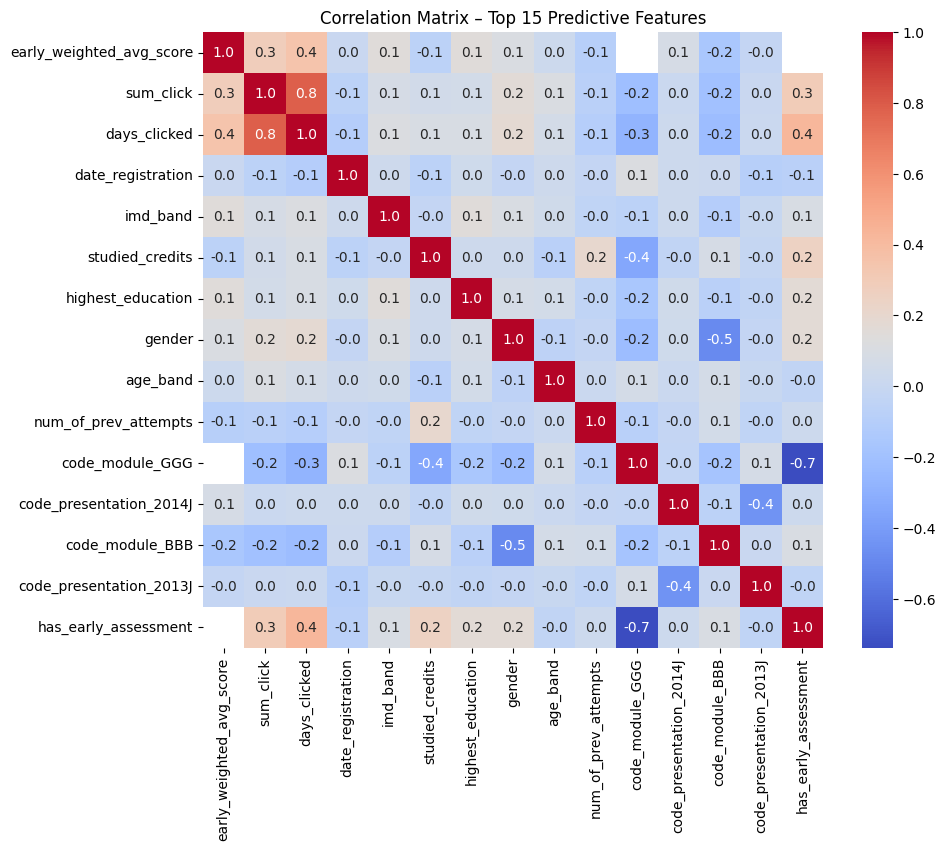

In [34]:
top_features = importances.head(15).index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(X[top_features].corr(), annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Correlation Matrix – Top 15 Predictive Features")
plt.show()

#### Distribution and patterns between key predictors

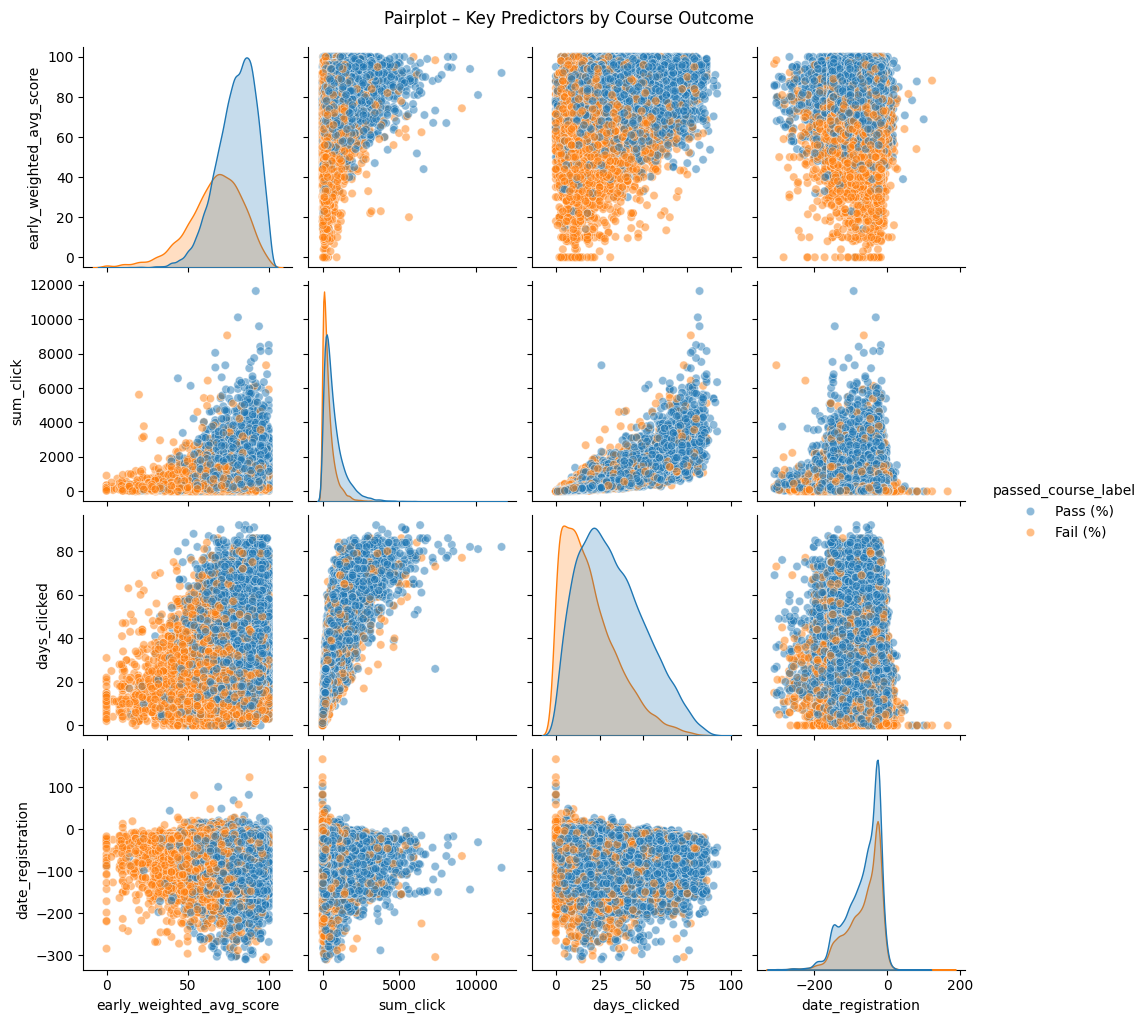

In [ ]:
df_cleaned['passed_course_label'] = df_cleaned['passed_course'].map({1: 'Pass (%)', 0: 'Fail (%)'})
 
sns.pairplot(df_cleaned, vars=["early_weighted_avg_score", "sum_click", "days_clicked", "date_registration"],
             hue="passed_course_label", plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot – Key Predictors by Course Outcome", y=1.02)
plt.show()

#### Class imbalance

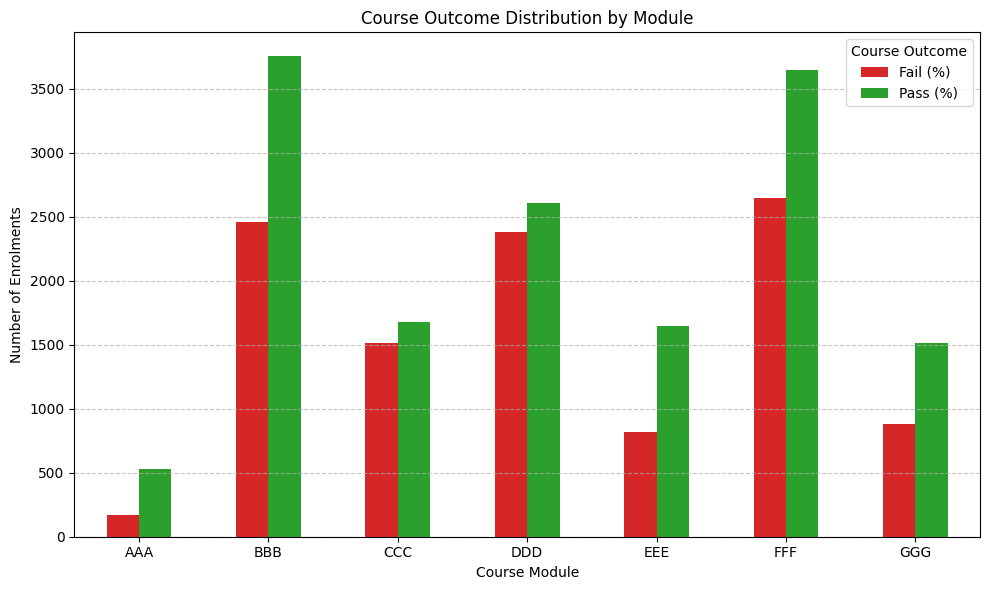

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Crosstab to count pass/fail outcomes for each course
ct = pd.crosstab(df_cleaned["code_module"], df_cleaned["passed_course_label"])

# Plot
ct.plot(kind="bar", stacked=False, figsize=(10, 6), color=["#d62728", "#2ca02c"])
plt.title("Course Outcome Distribution by Module")
plt.ylabel("Number of Enrolments")
plt.xlabel("Course Module")
plt.xticks(rotation=0)
plt.legend(title="Course Outcome")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Appendix 

#### Previous Correlation Plot 

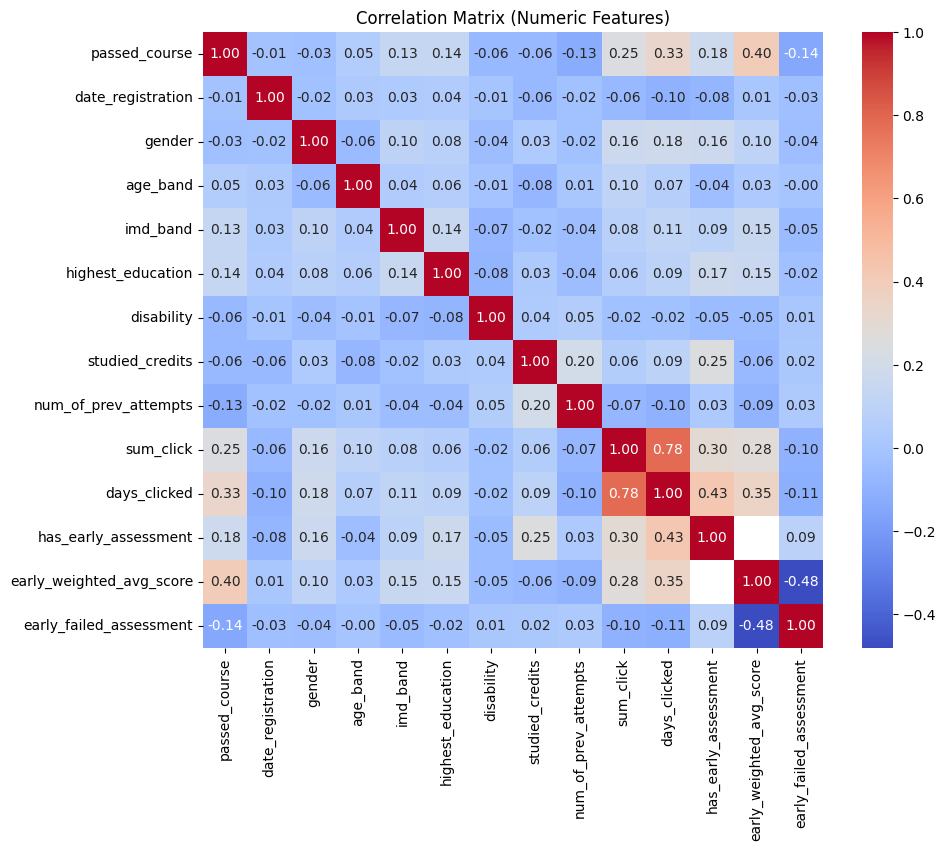

In [21]:
# Only numeric columns
numeric_cols = df_cleaned.select_dtypes(include=["int", "float"]).columns
 
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()